# Model Comparison: Black–Scholes, Monte Carlo GBM, and Heston

This notebook benchmarks several option pricing approaches for a European call.

Included:

1. Black–Scholes (analytical) — the reference value under constant volatility.
2. Monte Carlo (GBM) — standard estimator under geometric Brownian motion.
3. Monte Carlo (GBM with antithetic/control variate) — variance-reduced estimators.
4. Monte Carlo (Heston) — pricing under stochastic volatility.

Each method is evaluated by price, absolute error (vs analytical where anylictical is more appropriate), and runtime. It should be noted that the Heston results are not directly comparable with the Black–Scholes analytical values because the model's assumptions differ (stochastic volatility vs constant volatility).

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.black_scholes import black_scholes_price
from src.monte_carlo_pricing import price_european_mc
from src.utils import antithetic_sampling
from src.heston import simulate_heston_paths

plt.style.use("seaborn-v0_8-darkgrid")

## Parameters
A single test case is used across models for clarity.

In [2]:
S0 = 100.0   # spot
K = 100.0    # strike
T = 1.0      # time to maturity in years
r = 0.05     # risk-free rate
sigma = 0.2  # constant vol for GBM methods

steps = 252  # time steps for MC paths
M = 20000    # number of MC simulations

# Heston parameters (risk-neutral)
v0 = 0.04      # initial variance (0.2^2)
kappa = 2.0    # mean reversion speed
theta = 0.04   # long-run variance
sigma_v = 0.3  # vol of vol
rho = -0.7     # correlation between price and variance shocks

## Reference: Black–Scholes Analytical Price
This is the ground truth under the GBM assumption with constant volatility.

In [3]:
t0 = time.perf_counter()
bs_price = black_scholes_price(S0, K, T, r, sigma, option_type="call")
bs_ms = (time.perf_counter() - t0)*1e3
bs_price, bs_ms

(10.450583572185565, 0.7479999985662289)

## Monte Carlo (GBM): Standard Estimator
Simulates GBM paths and averages the discounted European call payoff.

In [4]:
t0 = time.perf_counter()
mc_price = price_european_mc(S0, K, r, sigma, T, M, steps, option_type="call")
mc_ms = (time.perf_counter() - t0)*1e3
abs_err_mc = abs(mc_price - bs_price)
mc_price, abs_err_mc, mc_ms

(10.512577539491117, 0.06199396730555229, 203.1111000032979)

## Monte Carlo (GBM): Antithetic Variates
Pairs Z and -Z to reduce variance of the estimator without changing bias.

In [5]:
def european_mc_antithetic(S0, K, r, sigma, T, M, steps):
    dt = T / steps
    Z = np.random.randn(M//2, steps)
    Z_full = antithetic_sampling(Z)  # shape (M, steps)
    S = S0 * np.exp(np.cumsum((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z_full, axis=1))
    payoff = np.maximum(S[:, -1] - K, 0)
    return np.exp(-r*T)*np.mean(payoff)

t0 = time.perf_counter()
mc_ant_price = european_mc_antithetic(S0, K, r, sigma, T, M, steps)
mc_ant_ms = (time.perf_counter() - t0)*1e3
abs_err_mc_ant = abs(mc_ant_price - bs_price)
mc_ant_price, abs_err_mc_ant, mc_ant_ms

(10.621486925940484, 0.1709033537549196, 139.66380000056233)

## Monte Carlo (GBM): Control Variate
Uses a correlated control with known expectation to reduce variance. The Black–Scholes price is used as the control expectation. The control variable is chosen as the discounted terminal price, which is strongly correlated with the payoff under GBM dynamics.

In [6]:
def european_mc_control_variate(S0, K, r, sigma, T, M, steps):
    dt = T / steps
    Z = np.random.randn(M, steps)
    S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z, axis=1))
    ST = S[:, -1]

    # Main payoff and correlated control variable
    payoff = np.exp(-r * T) * np.maximum(ST - K, 0)
    Y = np.exp(-r * T) * ST  # control variate

    # Optimal control coefficient
    var_Y = np.var(Y, ddof=1)
    if var_Y == 0:  # safeguard
        return np.mean(payoff)

    c_star = np.cov(payoff, Y, ddof=1)[0, 1] / var_Y

    # Known expectation of the control variable
    mu_Y = S0 

    # Adjusted Estimator
    adjusted = payoff - c_star * (Y - mu_Y)
    return np.mean(adjusted)

t0 = time.perf_counter()
mc_cv_price = european_mc_control_variate(S0, K, r, sigma, T, M, steps)
mc_cv_ms = (time.perf_counter() - t0)*1e3
abs_err_mc_cv = abs(mc_cv_price - bs_price)
mc_cv_price, abs_err_mc_cv, mc_cv_ms

(10.407223435874931, 0.043360136310633735, 163.93560000142315)

## Monte Carlo (Heston): Stochastic Volatility
Simulates paths under the Heston model and prices the European call by discounted average payoff. This result is **not** expected to match the Black–Scholes analytical value since the volatility process differs (stochastic vs constant).

In [7]:
t0 = time.perf_counter()
S_heston, V_heston = simulate_heston_paths(S0, v0, rho, kappa, theta, sigma_v, T, steps, M, r)
payoff_heston = np.maximum(S_heston[-1] - K, 0)
heston_price = np.exp(-r*T) * np.mean(payoff_heston)
heston_ms = (time.perf_counter() - t0)*1e3
heston_price, heston_ms

(10.320847464761384, 341.8614999973215)

## Results Summary
Absolute error is reported only for GBM-based methods relative to the Black–Scholes analytical price. Heston pricing is listed without error against Black–Scholes since the model assumptions differ.

In [8]:
rows = [
    {"Method": "Black–Scholes (Analytical)","Price": bs_price,    "Abs Error vs BS": 0.0,             "Runtime (ms)": bs_ms},
    {"Method": "MC GBM (Standard)",         "Price": mc_price,    "Abs Error vs BS": abs_err_mc,      "Runtime (ms)": mc_ms},
    {"Method": "MC GBM (Antithetic)",       "Price": mc_ant_price,"Abs Error vs BS": abs_err_mc_ant,  "Runtime (ms)": mc_ant_ms},
    {"Method": "MC GBM (Control Variate)",  "Price": mc_cv_price, "Abs Error vs BS": abs_err_mc_cv,   "Runtime (ms)": mc_cv_ms},
    {"Method": "MC Heston (Stoch Vol)",     "Price": heston_price,"Abs Error vs BS": np.nan,          "Runtime (ms)": heston_ms},
]
results = pd.DataFrame(rows)
results = results[["Method", "Price", "Abs Error vs BS", "Runtime (ms)"]]
results.round({"Price": 4, "Abs Error vs BS": 5, "Runtime (ms)": 1})

,Method,Price,Abs Error vs BS,Runtime (ms)
0,Black–Scholes (Analytical),10.4506,0.00000,0.7
1,MC GBM (Standard),10.5126,0.06199,203.1
2,MC GBM (Antithetic),10.6215,0.17090,139.7
3,MC GBM (Control Variate),10.4072,0.04336,163.9
4,MC Heston (Stoch Vol),10.3208,NaN,341.9


## Visual Comparison
Two simple charts: (i) absolute error vs analytical for GBM methods, (ii) runtimes for all methods.

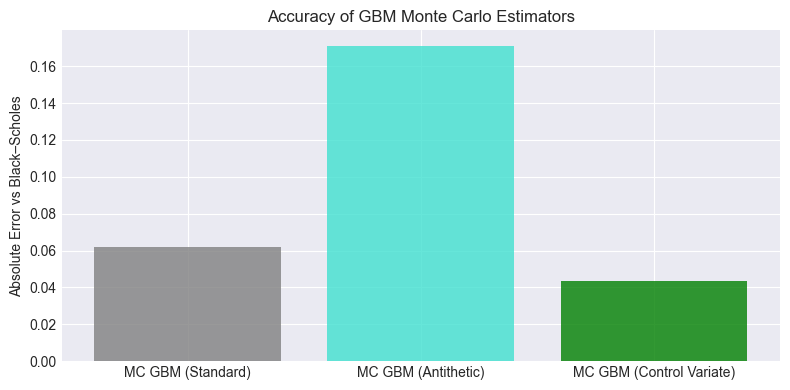

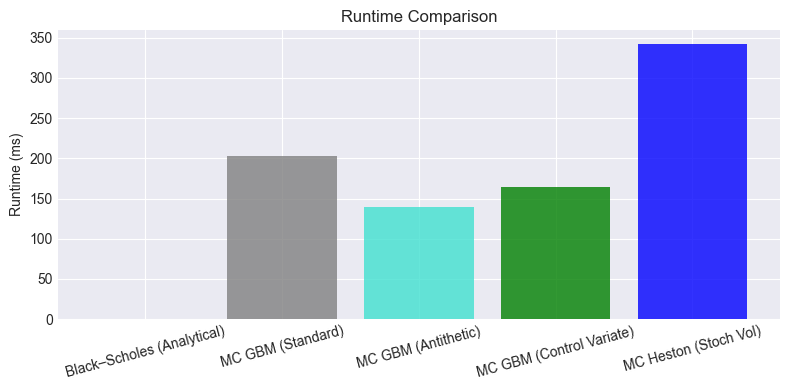

In [9]:
gbm_mask = results["Method"].str.contains("MC GBM")
plt.figure(figsize=(8,4))
plt.bar(results.loc[gbm_mask, "Method"], results.loc[gbm_mask, "Abs Error vs BS"], alpha=0.8,  color=["grey", "turquoise", "green"])
plt.ylabel("Absolute Error vs Black–Scholes")
plt.title("Accuracy of GBM Monte Carlo Estimators")
#plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.bar(results["Method"], results["Runtime (ms)"], alpha=0.8,  color=["black", "grey", "turquoise", "green", "blue"])
plt.ylabel("Runtime (ms)")
plt.title("Runtime Comparison")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## Summary 
- Under GBM, the analytical Black–Scholes value serves as the benchmark. Monte Carlo estimators converge to this value as the number of simulations increases.
- This is similar in principle to the covergence of Monte Carlo VaR to Parametric / Guassian VaR demonstrated in previous projects.
- Antithetic variates and control variates typically yield smaller absolute errors for a fixed simulation budget, demonstrating effective variance reduction.
- The Heston Monte Carlo prices using stochastic volatility and therefore should not be compared by error to Black–Scholes, it reflects a more realistic volatility dynamic. 
- Runtimes for the Heston model are significantly higher due to the joint simulation of price and variance.

Overall it is clear to see there are trade-offs between accuracy, assumptions, and computational cost in option pricing.